In [62]:
import warnings; 
warnings.simplefilter('ignore')
# %pip install pystan
# %pip install fbprophet

In [63]:

%pip install Prophet

Note: you may need to restart the kernel to use updated packages.


In [64]:
import pandas as pd
from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet

In [65]:
## 1-  Loading the Data of A51 
df = pd.read_csv("A51.csv", delimiter=";")
df.head()

,Datum,Uhrzeit,Bezeichnung,Intervall,D21Z,D21B,D22Z,D22B,D23Z,D23B,...,TB38Z,TB38B,TB39Z,TB39B,TB41Z,TB41B,ST58Z,ST58B,ST59Z,ST59B
0,01.01.2023,10:11,A 51,1,0,0,2,86,0,0,...,0,0,0,0,0,0,0,0,0,0
1,01.01.2023,10:10,A 51,1,0,0,1,13,0,0,...,0,0,0,0,0,0,0,0,0,0
2,01.01.2023,10:09,A 51,1,0,0,0,5,0,0,...,0,0,0,0,0,0,0,0,0,0
3,01.01.2023,10:08,A 51,1,0,0,1,19,0,0,...,0,0,0,0,0,0,0,0,0,0
4,01.01.2023,10:07,A 51,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Data Source 
https://datenplattform.darmstadt.de/verkehr/apps/opendata/#/\

In [66]:
df = df.drop(columns=["Intervall","Bezeichnung"])
# Create a boolean mask
mask = [not col.endswith('B') for col in df.columns] #according to the source of the Data the Columns that end with B is Time share with sensor deflection so it will be deleted  
# Use the mask to filter the DataFrame
df = df.filter(items=df.columns[mask])
df.head()

,Datum,Uhrzeit,D21Z,D22Z,D23Z,V24Z,V25Z,V26Z,D81Z,V82Z,...,TF39Z,TF41Z,TB32Z,TB35Z,TB37Z,TB38Z,TB39Z,TB41Z,ST58Z,ST59Z
0,01.01.2023,10:11,0,2,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,01.01.2023,10:10,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,01.01.2023,10:09,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,01.01.2023,10:08,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,01.01.2023,10:07,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:

df['Time'] = df[['Datum', 'Uhrzeit']].apply(lambda x: ' '.join(x), axis=1)
df['Time'] = pd.to_datetime(df['Time'])
df.head()

,Datum,Uhrzeit,D21Z,D22Z,D23Z,V24Z,V25Z,V26Z,D81Z,V82Z,...,TF41Z,TB32Z,TB35Z,TB37Z,TB38Z,TB39Z,TB41Z,ST58Z,ST59Z,Time
0,01.01.2023,10:11,0,2,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2023-01-01 10:11:00
1,01.01.2023,10:10,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2023-01-01 10:10:00
2,01.01.2023,10:09,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2023-01-01 10:09:00
3,01.01.2023,10:08,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2023-01-01 10:08:00
4,01.01.2023,10:07,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2023-01-01 10:07:00


In [68]:
df['Sum'] = df.iloc[:, 1:].sum(axis=1)
df.tail()

,Datum,Uhrzeit,D21Z,D22Z,D23Z,V24Z,V25Z,V26Z,D81Z,V82Z,...,TB32Z,TB35Z,TB37Z,TB38Z,TB39Z,TB41Z,ST58Z,ST59Z,Time,Sum
500907,01.01.2022,09:16,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,2022-01-01 09:16:00,4
500908,01.01.2022,09:15,0,0,0,0,0,0,2,2,...,0,0,0,0,0,0,0,0,2022-01-01 09:15:00,5
500909,01.01.2022,09:14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2022-01-01 09:14:00,0
500910,01.01.2022,09:13,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2022-01-01 09:13:00,3
500911,01.01.2022,09:12,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,2022-01-01 09:12:00,2


In [69]:
df = df.drop(columns=["Datum","Uhrzeit"])


df.set_index('Time', inplace=True)
df.tail()

,D21Z,D22Z,D23Z,V24Z,V25Z,V26Z,D81Z,V82Z,D91Z,V92Z,...,TF41Z,TB32Z,TB35Z,TB37Z,TB38Z,TB39Z,TB41Z,ST58Z,ST59Z,Sum
Time,,,,,,,,,,,,,,,,,,,,,
2022-01-01 09:16:00,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2022-01-01 09:15:00,0,0,0,0,0,0,2,2,0,0,...,0,0,0,0,0,0,0,0,0,5
2022-01-01 09:14:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-01 09:13:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2022-01-01 09:12:00,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [70]:
df.drop(df.columns.difference(['Time','Sum']), 1, inplace=True)

df.head()

,Sum
Time,
2023-01-01 10:11:00,7
2023-01-01 10:10:00,4
2023-01-01 10:09:00,0
2023-01-01 10:08:00,1
2023-01-01 10:07:00,2


In [71]:


df = df.resample('H').sum()
df.head()

,Sum
Time,
2022-01-01 09:00:00,229
2022-01-01 10:00:00,503
2022-01-01 11:00:00,628
2022-01-01 12:00:00,922
2022-01-01 13:00:00,1187


In [72]:


# calculate the IQR for each column in the DataFrame
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# define the lower and upper bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# create a boolean mask for the outlier rows in the DataFrame
outlier_mask = ~df.apply(lambda x: ((x < lower_bound) | (x > upper_bound)).any(), axis=1)

# select the rows without outliers
df_clean = df[outlier_mask]
df_clean.size
df= df_clean

In [73]:
df= df.reset_index()
df.columns = ["ds",'y']
df.head()

,ds,y
0,2022-01-01 09:00:00,229
1,2022-01-01 10:00:00,503
2,2022-01-01 11:00:00,628
3,2022-01-01 12:00:00,922
4,2022-01-01 13:00:00,1187


In [50]:
train_df= df[df.ds<"2023-01-01"]
test_df= df[df.ds>="2023-01-01"]


In [51]:
m = Prophet(interval_width=0.95, daily_seasonality=True)
m = m.fit(train_df)

16:28:28 - cmdstanpy - INFO - Chain [1] start processing
16:28:28 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
future = m.make_future_dataframe(periods=30,freq='H')
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-01 09:00:00,1253.225924,427.027113,2461.134279,1253.225924,1253.225924,168.907903,168.907903,168.907903,210.289897,210.289897,210.289897,-41.381995,-41.381995,-41.381995,0.0,0.0,0.0,1422.133827
1,2022-01-01 10:00:00,1253.168718,469.529631,2571.278045,1253.168718,1253.168718,218.251455,218.251455,218.251455,264.720968,264.720968,264.720968,-46.469513,-46.469513,-46.469513,0.0,0.0,0.0,1471.420174
2,2022-01-01 11:00:00,1253.111513,418.502246,2615.677181,1253.111513,1253.111513,278.730736,278.730736,278.730736,330.475975,330.475975,330.475975,-51.745239,-51.745239,-51.745239,0.0,0.0,0.0,1531.842249
3,2022-01-01 12:00:00,1253.054307,570.193459,2773.150137,1253.054307,1253.054307,361.357895,361.357895,361.357895,418.562835,418.562835,418.562835,-57.204939,-57.204939,-57.204939,0.0,0.0,0.0,1614.412202
4,2022-01-01 13:00:00,1252.997101,622.211335,2795.336287,1252.997101,1252.997101,450.343690,450.343690,450.343690,513.184053,513.184053,513.184053,-62.840363,-62.840363,-62.840363,0.0,0.0,0.0,1703.340791


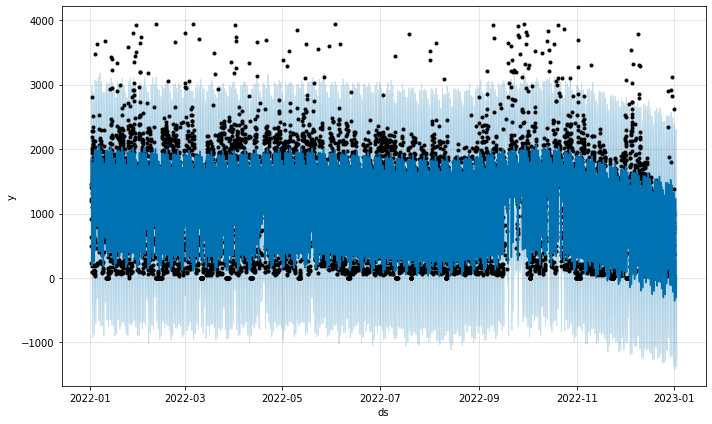

In [53]:

plot1 = m.plot(forecast)

In [54]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-01 09:00:00,1253.225924,427.027113,2461.134279,1253.225924,1253.225924,168.907903,168.907903,168.907903,210.289897,210.289897,210.289897,-41.381995,-41.381995,-41.381995,0.0,0.0,0.0,1422.133827
1,2022-01-01 10:00:00,1253.168718,469.529631,2571.278045,1253.168718,1253.168718,218.251455,218.251455,218.251455,264.720968,264.720968,264.720968,-46.469513,-46.469513,-46.469513,0.0,0.0,0.0,1471.420174
2,2022-01-01 11:00:00,1253.111513,418.502246,2615.677181,1253.111513,1253.111513,278.730736,278.730736,278.730736,330.475975,330.475975,330.475975,-51.745239,-51.745239,-51.745239,0.0,0.0,0.0,1531.842249
3,2022-01-01 12:00:00,1253.054307,570.193459,2773.150137,1253.054307,1253.054307,361.357895,361.357895,361.357895,418.562835,418.562835,418.562835,-57.204939,-57.204939,-57.204939,0.0,0.0,0.0,1614.412202
4,2022-01-01 13:00:00,1252.997101,622.211335,2795.336287,1252.997101,1252.997101,450.343690,450.343690,450.343690,513.184053,513.184053,513.184053,-62.840363,-62.840363,-62.840363,0.0,0.0,0.0,1703.340791


In [55]:
result = df.merge(forecast[["ds","yhat_lower","yhat_upper","yhat"]],on="ds")

In [56]:
result.tail()

,ds,y,yhat_lower,yhat_upper,yhat
8231,2023-01-01 06:00:00,91,-786.441489,1320.543214,240.770083
8232,2023-01-01 07:00:00,93,-613.876622,1473.426676,492.612045
8233,2023-01-01 08:00:00,95,-381.066584,1735.856503,657.413726
8234,2023-01-01 09:00:00,112,-341.320110,1702.524887,742.017284
8235,2023-01-01 10:00:00,34,-266.058840,1797.722124,794.570435


In [57]:
df.tail()

,ds,y
8231,2023-01-01 06:00:00,91
8232,2023-01-01 07:00:00,93
8233,2023-01-01 08:00:00,95
8234,2023-01-01 09:00:00,112
8235,2023-01-01 10:00:00,34


<AxesSubplot: xlabel='ds'>

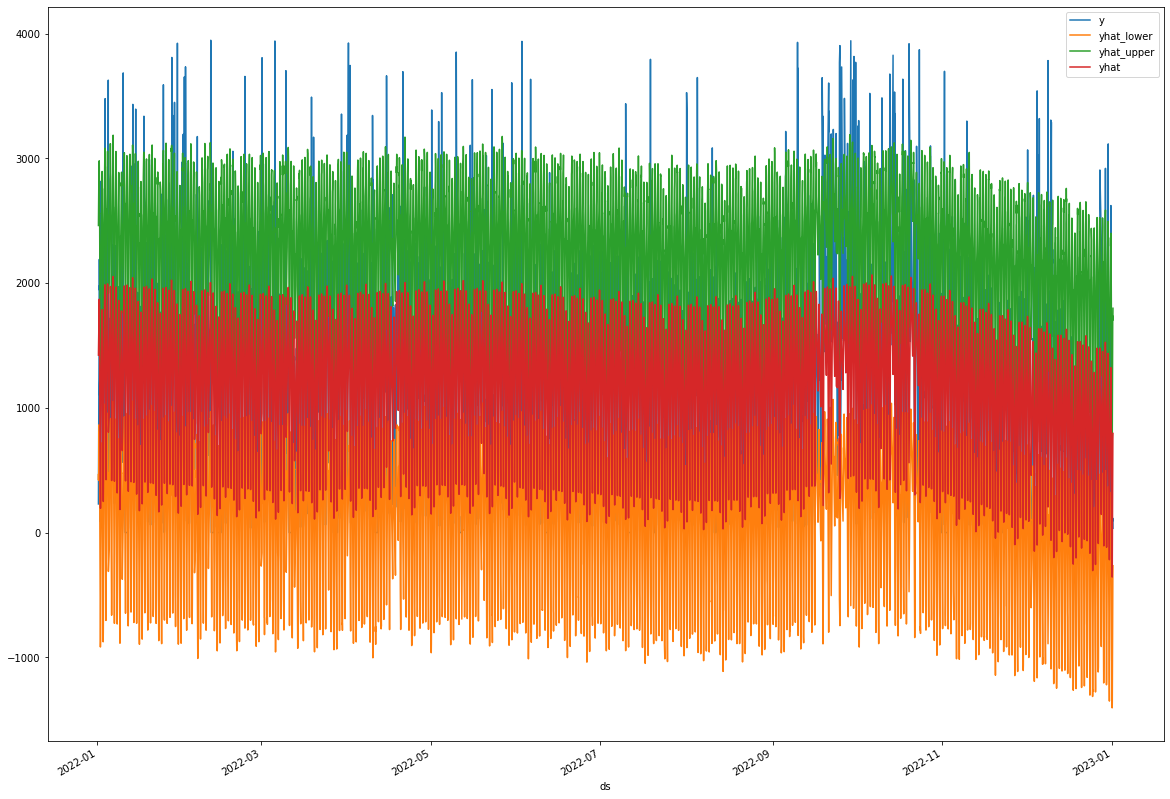

In [58]:
result.set_index("ds").plot(figsize=(20,15))

In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print(len(test_df['y']))
print(len(forecast['yhat'])) 

# Evaluating the predictions using mean absolute error and root mean squared error
mae = mean_absolute_error(test_df['y'], forecast['yhat'][:len(test_df)])
rmse = mean_squared_error(test_df['y'], forecast['yhat'][:len(test_df)], squared=False)


print('Mean absolute error:', mae)
print('Root mean squared error:', rmse)

11
8255
Mean absolute error: 1506.1956631074327
Root mean squared error: 1525.2878628500828


In [74]:
# Prophet model for time series forecast
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

# Visualization
import plotly.graph_objs as go

In [75]:
df.head()

,ds,y
0,2022-01-01 09:00:00,229
1,2022-01-01 10:00:00,503
2,2022-01-01 11:00:00,628
3,2022-01-01 12:00:00,922
4,2022-01-01 13:00:00,1187


In [76]:
# Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8236 entries, 0 to 8235
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      8236 non-null   datetime64[ns]
 1   y       8236 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 128.8 KB


In [77]:
# Train test split
df_train = df[df['ds']<='2022-12-30']
df_test = df[df['ds']>'2022-12-30']

# Print the number of records and date range for training and testing dataset.
print('The training dataset has', len(df_train), 'records, ranging from', df_train['ds'].min(), 'to', df_train['ds'].max())
print('The testing dataset has', len(df_test), 'records, ranging from', df_test['ds'].min(), 'to', df_test['ds'].max())

The training dataset has 8178 records, ranging from 2022-01-01 09:00:00 to 2022-12-30 00:00:00
The testing dataset has 58 records, ranging from 2022-12-30 01:00:00 to 2023-01-01 10:00:00


In [78]:
# Create the prophet model with confidence internal of 95%
m = Prophet(interval_width=0.95, n_changepoints=7)

# Fit the model using the training dataset
m.fit(df_train)

16:43:26 - cmdstanpy - INFO - Chain [1] start processing
16:43:26 - cmdstanpy - INFO - Chain [1] done processing


In [79]:
# Create a future dataframe for prediction
future = m.make_future_dataframe(periods=31)

# Forecast the future dataframe values
forecast = m.predict(future)

# Check the forecasted values and upper/lower bound
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
8204,2023-01-26,-30.076807,-1084.605157,1025.050813
8205,2023-01-27,-15.342007,-1116.188803,1071.577061
8206,2023-01-28,-115.393198,-1145.545855,962.595137
8207,2023-01-29,-248.464055,-1345.622426,872.506935
8208,2023-01-30,-244.897268,-1210.230551,791.794856


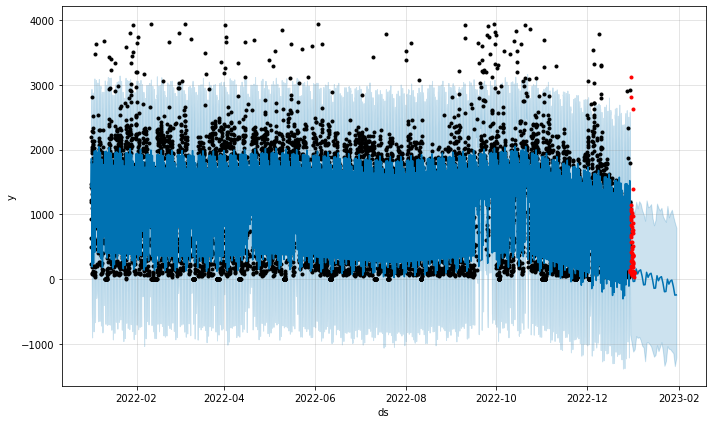

In [80]:
# Visualize the forecast
fig = m.plot(forecast)
ax = fig.gca()
ax.plot( df_test["ds"], df_test["y"], 'r.')

In [81]:
# Default change points
print(f'There are {len(m.changepoints)} change points. \nThe change points dates are \n{df.loc[df["ds"].isin(m.changepoints)]}')

There are 7 change points. 
The change points dates are 
                      ds     y
934  2022-02-11 10:00:00     0
1869 2022-03-24 13:00:00  1977
2803 2022-05-05 09:00:00  1905
3738 2022-06-14 16:00:00  2260
4672 2022-07-24 08:00:00   403
5607 2022-09-01 16:00:00  1498
6541 2022-10-18 12:00:00  1684


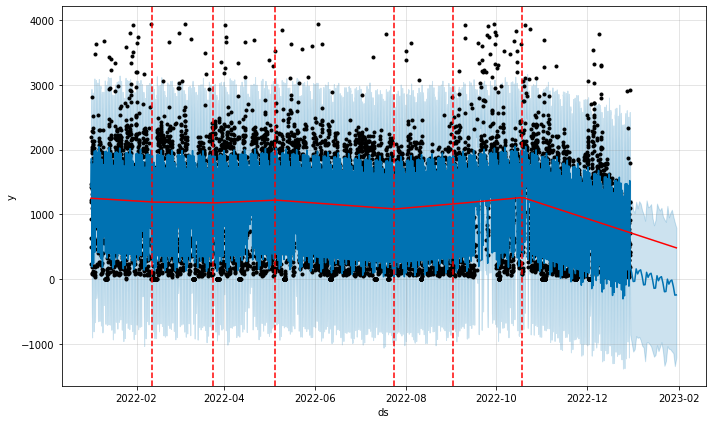

In [82]:
# Change points to plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [84]:
# Cross validation
df_cv = cross_validation(m, initial='300 days', period='60 days', horizon = '30 days', parallel="processes")
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-11-30 01:00:00,182.087634,-888.589940,1230.835012,134,2022-11-30
1,2022-11-30 02:00:00,50.667825,-967.183332,1100.920259,75,2022-11-30
2,2022-11-30 03:00:00,6.524583,-1169.435031,1071.003339,52,2022-11-30
3,2022-11-30 04:00:00,104.505544,-937.290818,1192.802792,89,2022-11-30
4,2022-11-30 05:00:00,339.594007,-730.467946,1494.912763,316,2022-11-30


In [85]:
# Model performance metrics
df_p = performance_metrics(df_cv)
df_p.head()


,horizon,mse,rmse,mae,mdape,smape,coverage
0,2 days 20:00:00,765390.602957,874.866049,635.651150,0.389371,0.909503,0.716418
1,2 days 21:00:00,777004.879652,881.478803,648.119118,0.416750,0.934812,0.716418
2,2 days 22:00:00,783378.213776,885.086557,657.515884,0.435899,0.958883,0.716418
3,2 days 23:00:00,786660.450552,886.938809,663.869166,0.435899,0.965539,0.716418
4,3 days 07:00:00,790041.208122,888.842623,670.744963,0.459554,0.974646,0.716418
